# **PJM Energy Consumption Prediction**

-------

**Name:** Naufal Prima Yoriko <br/>
**Email:** primayoriko@gmail.com <br/>

# **A. Prepare Data**

## **1. Import Data**

using Kaggle API

In [1]:
# install kaggle api program 
!pip install --upgrade --force-reinstall --no-deps kaggle

Processing /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303/kaggle-1.5.12-cp37-none-any.whl
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


please import your kaggle api keys

In [ ]:
from google.colab import files 
files.upload()

this is kaggle api key example of mine <br/>
`
{"username":"primayoriko","key":"580***ff5f3c6c55bc6***8424**7c80"}
`
<br/>
make your own kaggle api key, if dont know, see the tutorial post [here](https://www.kaggle.com/general/74235).


In [3]:
!mkdir ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("finished prepare api key file!")

mkdir: cannot create directory ‘/root/.kaggle’: File exists
finished prepare api key file!


In [4]:
 # test kaggle api program 
 !kaggle datasets list

ref                                                           title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
gpreda/reddit-vaccine-myths                                   Reddit Vaccine Myths                              232KB  2021-06-27 12:35:43           8370        716  1.0              
crowww/a-large-scale-fish-dataset                             A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           5132        404  0.9375           
imsparsh/musicnet-dataset                                     MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1744        144  1.0              
promptcloud/careerbuilder-job-listing-2020                    Careerbuilder Job 

download the dataset <br/>
**NOTE:**  make sure you have accept terms in the kaggle site, in case needed (some data need it) <br/>
https://www.kaggle.com/robikscube/hourly-energy-consumption

In [5]:
!kaggle datasets download -d robikscube/hourly-energy-consumption --force

  0% 0.00/11.4M [00:00<?, ?B/s]
100% 11.4M/11.4M [00:00<00:00, 150MB/s]


In [6]:
!ls

 AEP_hourly.csv      est_hourly.paruqet		     PJME_hourly.csv
 COMED_hourly.csv    FE_hourly.csv		     pjm_hourly_est.csv
 DAYTON_hourly.csv   hourly-energy-consumption.zip   PJM_Load_hourly.csv
 DEOK_hourly.csv    'kaggle (1).json'		     PJMW_hourly.csv
 DOM_hourly.csv     'kaggle (2).json'		     sample_data
 DUQ_hourly.csv      kaggle.json
 EKPC_hourly.csv     NI_hourly.csv


In [7]:
# Extract file
import zipfile,os

local_zip = './hourly-energy-consumption.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()

In [8]:
!ls

 AEP_hourly.csv      est_hourly.paruqet		     PJME_hourly.csv
 COMED_hourly.csv    FE_hourly.csv		     pjm_hourly_est.csv
 DAYTON_hourly.csv   hourly-energy-consumption.zip   PJM_Load_hourly.csv
 DEOK_hourly.csv    'kaggle (1).json'		     PJMW_hourly.csv
 DOM_hourly.csv     'kaggle (2).json'		     sample_data
 DUQ_hourly.csv      kaggle.json
 EKPC_hourly.csv     NI_hourly.csv


## **2. Load Data**

here we're just using data from DEOK `DEOK_hourly.csv` for this practice

In [9]:
import pandas as pd

df = pd.read_csv('DEOK_hourly.csv')

# **B. Explore Data**

In [10]:
df.head()

,Datetime,DEOK_MW
0,2012-12-31 01:00:00,2945.0
1,2012-12-31 02:00:00,2868.0
2,2012-12-31 03:00:00,2812.0
3,2012-12-31 04:00:00,2812.0
4,2012-12-31 05:00:00,2860.0


In [11]:
df.shape

(57739, 2)

In [12]:
df.isnull().sum()

Datetime    0
DEOK_MW     0
dtype: int64

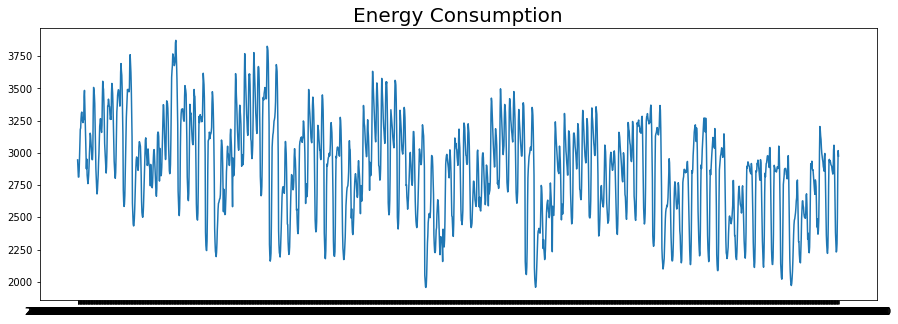

In [14]:
import matplotlib.pyplot as plt

datetimes = df['Datetime'].values[0:2000]
energy_usages  = df['DEOK_MW'].values[0:2000]
  
plt.figure(figsize=(20,5))
plt.plot(datetimes, energy_usages)
plt.title('Energy Consumption',
          fontsize=20);

# **C. Preprocess Data**

## **1. Make preprocess helper function**

### **1.1. X y helper function**

Help to create X with appropriate window size and y with appropriate feature size. 

In [27]:
import numpy as np

def create_X_y(ts: list, window_size: int, feature_size: int = 1) -> tuple:
  X, y = [], []

  if len(ts) - window_size <= 0:
      X.append(ts)
  else:
      for i in range(len(ts) - window_size):
          y.append(ts[i + window_size])
          X.append(ts[i:(i + window_size)])

  X, y = np.array(X), np.array(y)

  # Reshaping the X array to an LSTM input shape 
  X = np.reshape(X, (X.shape[0], X.shape[1], feature_size))

  return X, y    

### **1.1. train test split helper function**

help to split data with specified ratio

In [23]:
def split_data(X: list, y: list, train_test_split: int) -> tuple:
  X_train = X
  X_test = []

  y_train = y
  y_test = []

  index = round(len(X) * train_test_split)
  X_train = X[:(len(X) - index)]
  X_test = X[-index:]     

  y_train = y[:(len(X) - index)]
  y_test = y[-index:]

  return X_train, X_test, y_train, y_test

## **2. Declare constants**

probably needed in the process phase, too.

In [31]:
n_features = 1
n_windows = 80
n_batchs = 150
n_epochs = 25
# n_batch = math.floor(len(y)/n_windows)

train_test_ratio = 0.8

## **3. Do preprocess pipeline**

### **3.1. drop null data**

In [25]:
df = df.dropna()

## **4. Split data**

In [28]:
# from sklearn.model_selection import train_test_split

# axis_value = df['Datetime'].values
feature_value = df['DEOK_MW'].values

X, y = create_X_y(ts=feature_value, window_size=n_windows, feature_size=n_features)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = split_data(X, y, train_test_split=train_test_ratio)

In [ ]:
train_set = windowed_dataset(y, window_size=n_windows, batch_size=n_batch, shuffle_buffer=1000)

# **D. Process Data**

## **1. Create model**

In [32]:
import tensorflow as tf

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [33]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

## **2. Train Data**

In [35]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

keras_dict = {
      'x': X_train,
      'y': y_train,
      'validation_data': (X_test, y_test),
      'batch_size': n_batchs,
      'epochs': n_epochs,
      'shuffle': False,
      'callbacks': [
           EarlyStopping(patience=10, restore_best_weights=True),
           ReduceLROnPlateau(patience=8)
      ]
  }

history = model.fit(**keras_dict)

Epoch 1/25
77/77 [==============================] - 31s 359ms/step - loss: 3043.3901 - mae: 3043.8896 - val_loss: 3119.4272 - val_mae: 3119.9248
Epoch 2/25
77/77 [==============================] - 27s 349ms/step - loss: 3042.8516 - mae: 3043.3518 - val_loss: 3118.8328 - val_mae: 3119.3301
Epoch 3/25
77/77 [==============================] - 26s 346ms/step - loss: 3042.0139 - mae: 3042.5151 - val_loss: 3117.6414 - val_mae: 3118.1411
Epoch 4/25
77/77 [==============================] - 26s 346ms/step - loss: 3040.1350 - mae: 3040.6333 - val_loss: 3114.6738 - val_mae: 3115.1716
Epoch 5/25
77/77 [==============================] - 27s 349ms/step - loss: 3034.1243 - mae: 3034.6235 - val_loss: 3102.8936 - val_mae: 3103.3914
Epoch 6/25
77/77 [==============================] - 27s 349ms/step - loss: 2989.1162 - mae: 2989.6165 - val_loss: 2954.7742 - val_mae: 2955.2729
Epoch 7/25
77/77 [==============================] - 27s 354ms/step - loss: 1456.7965 - mae: 1457.2964 - val_loss: 690.3076 - val_m

## **3. Visualize Result**

by create graph of it's MAE and loss 

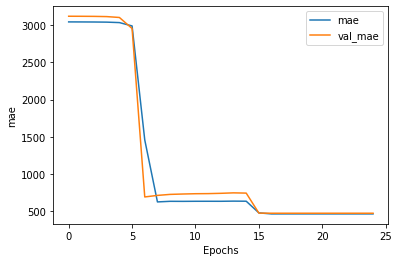

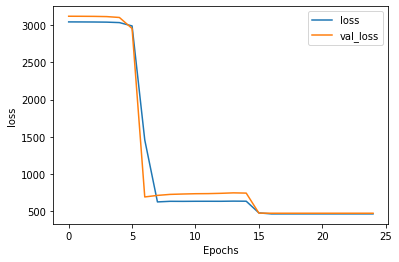

In [36]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "mae")
plot_graphs(history, "loss")

here is relative MAE value to total data

**A. Train relative MAE**

In [44]:
print((462.8622/(df.shape[0] * train_test_ratio)) * 100, "%")

1.0020571017856215 %


**B. Test relative MAE**

In [45]:
print((471.8848/(df.shape[0] * (1 - train_test_ratio))) * 100, "%")

4.086361038466202 %


# **E. Attachment**

## **1. Old result with 100 epoch**

In [19]:
import tensorflow as tf

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
80/80 [==============================] - 61s 705ms/step - loss: 3104.4976 - mae: 3104.9980
Epoch 2/100
80/80 [==============================] - 56s 698ms/step - loss: 3104.2542 - mae: 3104.7534
Epoch 3/100
80/80 [==============================] - 56s 695ms/step - loss: 3104.0127 - mae: 3104.5120
Epoch 4/100
80/80 [==============================] - 56s 692ms/step - loss: 3103.6660 - mae: 3104.1667
Epoch 5/100
80/80 [==============================] - 56s 695ms/step - loss: 3103.1023 - mae: 3103.6030
Epoch 6/100
80/80 [==============================] - 56s 701ms/step - loss: 3101.9717 - mae: 3102.4717
Epoch 7/100
80/80 [==============================] - 56s 697ms/step - loss: 3098.9619 - mae: 3099.4622
Epoch 8/100
80/80 [==============================] - 56s 695ms/step - loss: 3086.2959 - mae: 3086.7949
Epoch 9/100
80/80 [==============================] - 57s 705ms/step - loss: 2790.3955 - mae: 2790.8962
Epoch 10/100
80/80 [==============================] - 57s 701ms/step - lo